In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def create_data():
    iris = load_iris()
    X = iris.data[:100,:2]
    y = iris.target[:100]
    return X, y

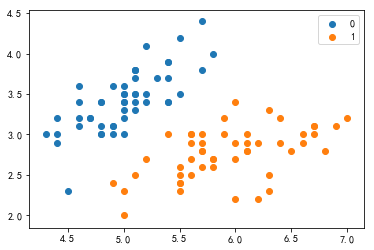

In [5]:
#画出数据模型
X , y = create_data()
plt.scatter(X[y==0, 0], X[y==0, 1], label = "0")
plt.scatter(X[y==1, 0], X[y==1, 1], label = "1")
plt.legend()
plt.savefig("原始数据")
plt.show()

In [28]:
class Adaboost:
    """定义Adaboost类"""
    
    def __init__(self, n_estimators = 50, learning_rate = 1.0):
        """初始化整体分类器的参数"""
        self.clf_num = n_estimators #有多少个弱分类器
        self.learning_rate = learning_rate
    
    def init_args(self, datasets, labels):
        """初始化弱分类器参数"""
        self.X = datasets
        self.Y = labels
        self.M, self.N = datasets.shape #m的数据样本，n个特征
        
        #初始化原始数据每一个点的权重为平均权重
        self.weights = [1.0/self.M]*self.M
        
        self.aplha = []
        self.clf_sets = []
        
    def _G(self, features, labels, weights):
        """弱分类器"""
        """是一个决策树桩算法的实现"""
        m = len(features)
        error = 10000.0 #设置为最大值
        best_v = 0.0 #选取最优分类点
        
        #构建特征度量
        features_min = min(features)
        features_max = max(features)
       
        n_step = (features_max - features_min + 
                  self.learning_rate)//self.learning_rate
        
#         print("迭代：",n_step)
        direct, compare_array = None, None
        #求解最优切分点
        for i in range(1, int(n_step)):
            #遍历特征
            v = features_min + self.learning_rate*i
#             print()
            #划分区域
            if v not in features:
                compare_array_positive = np.array([
                    1 if features[k] > v else -1 for k in range(m)
                ])
                #计算此种情况下数据的损失率
                weight_erroe_positive = sum([
                    weights[k] for k in range(m) 
                    if compare_array_positive[k] != labels[k]
                ])
                compare_array_nagetive = np.array([
                    -1 if features[k] > v else 1 for k in range(m)
                ])
                
                weight_erroe_nagative = sum([
                    weights[k] for k in range(m) 
                    if compare_array_nagetive[k] != labels[k]
                ])
                
                #选择最优的标签类型
                if weight_erroe_positive < weight_erroe_nagative:
                    weights_error = weight_erroe_positive
                    _compare_array = compare_array_positive
                    direct = "positive"
                else:
                    weights_error = weight_erroe_nagative
                    _compare_array = compare_array_nagetive
                    direct = "negative"
                    
                if weights_error < error:
                    error = weights_error
                    compare_array = _compare_array
                    best_v = v
                    
                
        return best_v,direct,error, compare_array
        

        
        
    def _alpha(self, error):
        """弱分类器系数"""
        return 0.5 * np.log((1 - error)/error)
    
    def _w(self, a, clf, Z):
        """权重更新"""
        for i in range(self.M):
            self.weights[i] = self.weights[i] * np.exp(
            -1 * a * self.Y[i] * clf[i])/Z
    
    def _Z(self, weights, a, clf):
        """规范化因子"""
        return  sum([weights[i] * np.exp(-1 * a * self.Y[i]*
                                            clf[i]) for i in range(self.M)])
        
    def G(self, x, v, direct):
        """决策树桩"""
        if direct == "positive":
            return 1 if x > v else -1
        else:
            return -1 if x > v else 1
    
    def fit(self, X, y):
        """训练数据"""
        #1.初始化参数
        self.init_args(X, y)
        best_clf_error, best_v, clf_result = 10000.0, None, None
        axis = 0
        #2.寻找模型的最佳数据点
        for epoch in range(self.clf_num):
            for j in range(self.N):
                #遍历每一维度的数据特征
                features = self.X[:, j]
                v, direct, error, compare_array = self._G(features,
                                                         self.Y, self.weights)
                if error < best_clf_error:
                    best_clf_error = error
                    best_v = v
                    final_direct = direct
                    clf_result = compare_array
                    axis = j#记录特征维度
                    
                if best_clf_error==0:
                    break
            #3.权重更新和分类器系数计算
            #3.1系数
            a = self._alpha(best_clf_error)
            self.aplha.append(a)
            #3.2记录每一分类器的参数
            self.clf_sets.append((axis, best_v, final_direct))
            #3.3规范化因子
            Z = self._Z(self.weights, a, clf_result)
            #3.4 权值更新
            self._w(a, clf_result, Z)

    
    def predict(self, feature):
        """单例评测"""
        result = 0.0
        for i in range(len(self.clf_sets)):
            axis, clf_v, direct = self.clf_sets[i]
#             print(self.clf_sets[i])
            f_input = feature[axis]
            result += self.aplha[i] * self.G(f_input, clf_v, direct)
#             print(result)
        # sign
#            ? print("最优分类器参数：",self.clf_sets[i])
        return 1 if result > 0 else -1
    
    def score(self, X_test, y_test):
        """评测数据集"""
        right_count = 0
        for i in range(len(X_test)):
            feature = X_test[i]
            if self.predict(feature) == y_test[i]:
                right_count += 1
        #print(right_count)

        return right_count / len(X_test)

In [29]:
import numpy as np
X = np.arange(10).reshape(10, 1)
Y = np.array([1, 1, 1, -1, -1, -1, 1, 1, 1, -1])
clf = Adaboost(n_estimators=3, learning_rate=0.5)
clf.fit(X, Y)
clf.predict([5])

1

In [30]:
X, y = create_data()
#改写数据标注“0”为“-1”
for i in range(len(y)):
    if y[i] == 0:
        y[i] = -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [31]:
clf = Adaboost(n_estimators=10, learning_rate=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)
# print(X_test,y_test)

0.48484848484848486

In [33]:
# 100次结果
result = []
for i in range(1, 101):
    X, y = create_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    clf = Adaboost(n_estimators=100, learning_rate=0.2)
    clf.fit(X_train, y_train)
    r = clf.score(X_test, y_test)
    # print('{}/100 score：{}'.format(i, r))
    result.append(r)

print('average score:{:.3f}%'.format(sum(result)))

average score:24.515%
